# mTurk_Results_analysis
This performs a basic analysis of mTurk results for any results file

In [90]:
import pandas as pd
import statistics
from collections import defaultdict
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

myth_name = '5G'
sample_size = '100'
date = '101921'

file_name = f'../data/samples/{myth_name}/myth_{myth_name}_sample_{sample_size}_{date}_results.csv'

# Make sure to comment out the tested myth
topics = ['Answer.Prevention/Treatment - Disinfectants.on',
 'Answer.Prevention/Treatment - Home Remedy.on',
 'Answer.Prevention/Treatment - Technology.on',
 'Answer.Prevention/Treatment - Weather.on',
 'Answer.Prevention/Treatment - Masks.on',
 'Answer.Prevention/Treatment - Other.on',
 'Answer.Coronavirus Spread - Transmission.on',
 'Answer.Coronavirus Spread - Other.on',
 'Answer.Coronavirus Origins.on',
 'Answer.Coronavirus Testing.on',
 'Answer.Coronavirus Government Policy.on',
 'Answer.Coronavirus Humor/Sarcasm.on',
 'Answer.Coronavirus Coping Strategies.on',
 'Answer.Coronavirus New Cases.on']

if myth_name == 'disinfectants': topics.remove('Answer.Prevention/Treatment - Disinfectants.on')
elif myth_name == 'home_remedies': topics.remove('Answer.Prevention/Treatment - Home Remedy.on')
elif myth_name == 'weather': topics.remove('Answer.Prevention/Treatment - Weather.on')
elif myth_name == 'origins': topics.remove('Answer.Coronavirus Origins.on')
elif myth_name == 'masks': topics.remove('Answer.Prevention/Treatment - Masks.on')

df = pd.read_csv(file_name)
list(df)

['HITId',
 'HITTypeId',
 'Title',
 'Description',
 'Keywords',
 'Reward',
 'CreationTime',
 'MaxAssignments',
 'RequesterAnnotation',
 'AssignmentDurationInSeconds',
 'AutoApprovalDelayInSeconds',
 'Expiration',
 'NumberOfSimilarHITs',
 'LifetimeInSeconds',
 'AssignmentId',
 'WorkerId',
 'AssignmentStatus',
 'AcceptTime',
 'SubmitTime',
 'AutoApprovalTime',
 'ApprovalTime',
 'RejectionTime',
 'RequesterFeedback',
 'WorkTimeInSeconds',
 'LifetimeApprovalRate',
 'Last30DaysApprovalRate',
 'Last7DaysApprovalRate',
 'Input.id_str',
 'Input.date',
 'Input.full_text_censored',
 'Input.myth',
 'Answer.Coronavirus Coping Strategies.on',
 'Answer.Coronavirus Government Policy.on',
 'Answer.Coronavirus Humor/Sarcasm.on',
 'Answer.Coronavirus New Cases.on',
 'Answer.Coronavirus Origins.on',
 'Answer.Coronavirus Spread - Other.on',
 'Answer.Coronavirus Testing.on',
 'Answer.Prevention/Treatment - Disinfectants.on',
 'Answer.Prevention/Treatment - Home Remedy.on',
 'Answer.Prevention/Treatment - Ot

In [91]:
# Declare rater number
rater_num = 3

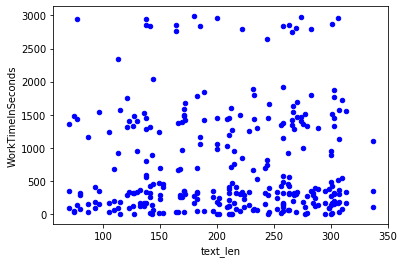

In [92]:
for col in list(df):
    if col.startswith('Input.full_text'):
        full_text_col_name = col
        break
df['text_len'] = df[full_text_col_name].apply(len)
df.plot(kind='scatter',x='text_len',y='WorkTimeInSeconds',color='blue')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5a139d290>,
      dtype=object)

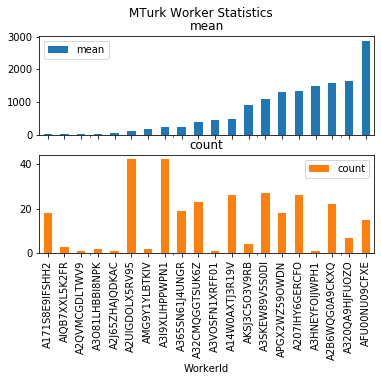

In [93]:
# Group by WorkerID, and take the average time to complete to look
# for outliers that may have completed the tasks too fast.
df.groupby('WorkerId')['WorkTimeInSeconds']\
  .agg(['mean', 'count'])\
  .sort_values(by='mean')\
  .plot(subplots=True, kind='bar', title='MTurk Worker Statistics')

In [94]:
# The radio buttons from the MTurk form store their boolean result in a
# single column; we will combine these into their respective questions.

null_task_ids = set()

def merge_radios(row, topic):
    """
    To be used in an `apply` method to combine boolean radio buttons into a
    single column
    """
    if row['Answer.{}_yes.on'.format(topic)]:
        return 'yes'
    elif row['Answer.{}_no.on'.format(topic)]:
        return 'no'
    elif row['Answer.{}_unsure.on'.format(topic)]:
        return 'unsure'
    elif 'Answer.{}_broken_links.on'.format(topic) in list(df) and row['Answer.{}_broken_links.on'.format(topic)]:
        return 'broken_links'
    else:
        if topic == 'myth_supports':
            # Because this question is conditonal, some tasks might not have this field
            # Assume they are NO
            return 'no'
        
        raise ValueError("The chosen choice is not defined.") # If the worker didn't choose any choices
        # print(row.AssignmentId)
        # null_task_ids.add(row.HITId)
        # return None
    
df['is_myth'] = df.apply (lambda row: merge_radios(row, 'myth'), axis=1)
df['is_myth_supports'] = df.apply (lambda row: merge_radios(row, 'myth_supports'), axis=1)

print('There are {} tasks ids with null values'.format(len(null_task_ids)))

There are 0 tasks ids with null values


In [95]:
# Drop tasks with null
df = df[~df['HITId'].isin(list(null_task_ids))]

In [96]:
# Drop all tasks performed by rejected workers
rejected_workers = ["AAXYYH9MI3PJM"]

df = df[~df['WorkerId'].isin(rejected_workers)]

df.shape

(300, 55)

In [97]:
# is_myth Answer Statistics

def check_agree_on(col):
    # Group the results by Task ID and their answer to the gun_violence question, then
    # count the number of records in those groups. This determines how many answers
    # there were per choice, per task. Rename the count column.
    df_gun_violence_counts = df.groupby(['HITId', col]).size().to_frame().reset_index()
    df_gun_violence_counts.rename(columns={0: 'count'}, inplace=True)

    # All three workers answered 'unsure'
    unsure = df_gun_violence_counts[col] == 'unsure'
    three = df_gun_violence_counts['count'] >= 2
    num_all_unsure = len(df_gun_violence_counts[unsure & three])

    # All three workers answered 'yes'
    yes = df_gun_violence_counts[col] == 'yes'
    num_all_yes = len(df_gun_violence_counts[yes & three])

    # All three workers answered 'no'
    no = df_gun_violence_counts[col] == 'no'
    num_all_no = len(df_gun_violence_counts[no & three])

    print('Agreed on "yes": {}\nAgreed on "No": {}\nAgreed on "Unsure": {}'.format(num_all_yes, num_all_no, num_all_unsure))

    # There was no majority, answers were 'yes', 'no', and 'unsure'
    df_gun_violence_count_size = df_gun_violence_counts.groupby('HITId').size().to_frame().rename(columns={0: 'count'})
    # df_gun_violence_count_size[df_gun_violence_count_size['count'] == 3]

In [98]:
check_agree_on(col="is_myth")

Agreed on "yes": 98
Agreed on "No": 2
Agreed on "Unsure": 0


In [99]:
check_agree_on(col="is_myth_supports")

Agreed on "yes": 33
Agreed on "No": 49
Agreed on "Unsure": 8


## Check data validity

In [100]:
# These columns must not be None
answer_cols = [ e for e in list(df) if e.startswith("Answers.") ]
for col in answer_cols:

    for v in df[col]:
        if v is None:
            raise ValueError('None exists in {}'.format(col))

In [101]:
# Check that each task has three rated values
for v in df.groupby('HITId').size():
    if v != rater_num:
        raise ValueError("There is a task with raters not equal to {}, found {}.".format(rater_num, v))
print('Every task has {} workers for each'.format(rater_num))

Every task has 3 workers for each


# Agreement Computation

## 1. Task-based agreement

In [102]:
def get_task_based_rating(df, answer_col, rater_num=5):
    """
    Task-based rating score computation
    
    Args:
        df:
            A dataFrame with columns ['WorkerId', 'HITId', 'is_parenting'] ordered by ['HITId', 'WorkerId']
        answer_col:
            Column name to compute rating scores
        rater_num:
            Number of raters for each task
            
    Return:
        A list of task-based rating scores
    """
    
    rating_scores = []
    for i in range(0, df.shape[0], rater_num):
        if len(set(df.iloc[i:i + rater_num]['HITId'])) != 1:
            raise ValueError('Each task must contains {} rates, wrong at {}'.format(rater_num, i))
        answers = df.iloc[i:i + rater_num][answer_col].tolist()
        
        # Get number of majority
        majority_num = max(df.iloc[i:i + rater_num].groupby(answer_col).size())
        # Store rating score
        rating_scores.append(round(float(majority_num / rater_num), 2))
        
    return rating_scores

In [103]:
# Gun_violence
def check_task_based_score(col):
    df_task_based = df[['WorkerId', 'HITId', col]].sort_values(by=['HITId', 'WorkerId'])

    # DataFrame for rating scores
    df_task_based_rates = df_task_based.drop_duplicates(subset=['HITId'])
    df_task_based_rates.drop(['WorkerId', col], axis=1, inplace=True)

    # Compute scores
    rating_scores = get_task_based_rating(df_task_based, answer_col=col, rater_num=rater_num)
    df_task_based_rates = df_task_based_rates.assign(rating_scores=rating_scores)

    # Sort and check statistics
    df_task_based_rates.sort_values(by=['rating_scores'], inplace=True)

    # Check stats
    stats_task_based_gun_violence = df_task_based_rates.groupby('rating_scores').size().to_frame().reset_index().rename(columns={0: 'count'})
    ax = stats_task_based_gun_violence.plot(kind='bar', x='rating_scores', y='count', color='blue', \
                   title='{}: stats of task-based agreement'.format(col))

    for i, v in enumerate(stats_task_based_gun_violence['count']):
        ax.text(i-0.05, v+5, str(v), va='center', fontsize=10, fontweight='bold')
        
    df_gun_violence_task_based_rates = df_task_based_rates.sort_values(by=['rating_scores'], ascending=False)
    print(df_gun_violence_task_based_rates.head(10))
    
    only_high_task_based_tweet_ids = df_gun_violence_task_based_rates[df_gun_violence_task_based_rates['rating_scores'] >= 0.8]['HITId'].values
    print("There are {} tweets with high task-based scores".format(only_high_task_based_tweet_ids.shape[0]))
    
    avg_score = statistics.mean(df_gun_violence_task_based_rates['rating_scores'].values)
    print("Avg task-based score for {} = {}".format(col, avg_score))
    
    # df_high_task_based = df_gun_violence_task_based_rates[df_gun_violence_task_based_rates["is_myth_score"] > 0.9]
    df_gun_violence_task_based_rates.to_csv('myth_5G_high_task_based.csv')

                              HITId  rating_scores
123  3KTZHH2ONKZ4AQZ45ADZF7BWMGE8MD            1.0
63   3ABAOCJ4RAOAGUZ0R4UZ1YWWGM0MQ2            1.0
189  34XASH8KLS6PGIYLRRFA1T6MBQEPME            1.0
9    3087LXLJ6O0GMR2KOJW7R2L56HQ0FB            1.0
12   30UZJB2POJWK1M8S1U1H7OSZKZW35Q            1.0
99   31JUPBOORPOK48HJ5YCKFUW7MBO8LB            1.0
195  31MBOZ6PAQBMGB7WMASPHGSQC29CLL            1.0
54   31N9JPQXIR23LJLXKFM55ZTVUPEHN1            1.0
126  32L724R85N43KZ8U6CHI90Z5UHUPIY            1.0
141  32ZCLEW0B14ZFAS0OU2IL1E57WJPJA            1.0
There are 91 tweets with high task-based scores
Avg task-based score for is_myth = 0.9703


/home/app59/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


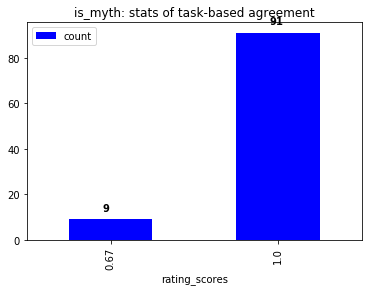

In [104]:
check_task_based_score(col='is_myth')

/home/app59/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


                              HITId  rating_scores
165  3ZXV7Q5FJD80GJX00ZPRM3N6F6NFCJ            1.0
192  3EPG8DX9LMAR8BDFZSYOKRV0PVO5P4            1.0
177  3EQVJH0T4251GWQHHB8HEYZNJ70HT2            1.0
261  3QX22DUVOQ12L2VHD3O97LV4XEFMVW            1.0
51   3PN6H8C9R6AFPKM6PFYAS8UX3QMAD1            1.0
219  3RWB1RTQDL7AVTWHXQ5RWB5RRLP8P9            1.0
144  34ZTTGSNJZ8OOGYP07EM9TO0Z01HQO            1.0
87   3ZUE82NE0CLY4G7NJN9MKHRNPF2F8D            1.0
285  3ZTE0JGGCGCUMWATZ28H9XWK77ECO2            1.0
9    3087LXLJ6O0GMR2KOJW7R2L56HQ0FB            1.0
There are 48 tweets with high task-based scores
Avg task-based score for is_myth_supports = 0.7944


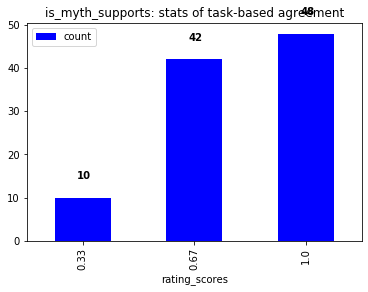

In [105]:
check_task_based_score(col='is_myth_supports')

## 2. Worker-based agreement

Compute the score by comparing each task of each worker to the other. If an answer of a worker is equal to its majority of the corresponding task, then the number of correct answers of the work increases by one. The avg_score of each worker is computed by dividing the number of correct answers by total number of tasks that the worker have done.

In [106]:
def get_worker_based_rating(df, answer_col):
    """
    Worker-based rating score computation
    
    Args:
        df:
            A dataFrame with columns ['WorkerId', 'HITId', 'is_parenting'] ordered by ['WorkerId', 'HITId']
        answer_col:
            Column name to compute rating scores
            
    Return:
        A list of worker-based rating scores
    """
    df = df.reset_index(drop=True)
    
    # Variables for rating score computation
    current_woker_id = ""
    total_task_num = 0
    correct_answer_num = 0
    
    rating_scores = []
    total_task_nums = []
    for idx, row in df.iterrows():
        worker_id = row['WorkerId']
        task_id = row['HITId']
        answer = row[answer_col]
        
        # Get next worker ID
        if worker_id != current_woker_id:
            current_woker_id = worker_id
            
            if idx > 0:
                # Compute rating scores
                rating_scores.append(correct_answer_num / total_task_num)
                total_task_nums.append(total_task_num)

                # Reset variables
                total_task_num = 0
                correct_answer_num = 0
            
        # Check whether the answer is the same as majority answer
        df_answer_counts = df[df['HITId'] == task_id].groupby(answer_col).size().to_frame().rename(columns={0: 'count'}).sort_values(by=['count'], ascending=False).reset_index()
        majority_count = df_answer_counts.iloc[0]['count']
        
        try:
            answer_count = df_answer_counts[df_answer_counts[answer_col] == answer].iloc[0]['count']
        except Exception as e:
            print(e)
            print(df[df['HITId'] == task_id])
        
        if answer_count == majority_count and majority_count > 1:
            is_majority = True
        else:
            is_majority = False
        
        # Counting if the answer is the same as the majority vote
        if is_majority:
            correct_answer_num += 1
        total_task_num += 1
        
        # Last task
        if idx + 1 > max(df.index):
            # Compute rating scores
            rating_scores.append(correct_answer_num / total_task_num)
            total_task_nums.append(total_task_num)
    
    # print(len(set(df['WorkerId'].values)))
    # print("Rating score: " + str(len(rating_scores)))
    # print("Total task number: " + str(len(total_task_nums)))
    
    return rating_scores, total_task_nums

In [107]:
# Gun violence
def check_worker_based_score(col):
    df_worker_based = df[['WorkerId', 'HITId', col]].sort_values(by=['WorkerId', 'HITId'])

    df_worker_based_rates = df_worker_based.drop_duplicates(subset=['WorkerId'])
    df_worker_based_rates.drop(['HITId', col], axis=1, inplace=True)

    # # Compute scores
    rating_scores, total_task_nums = get_worker_based_rating(df_worker_based, answer_col=col)
    df_worker_based_rates = df_worker_based_rates.assign(rating_scores=rating_scores)
    df_worker_based_rates = df_worker_based_rates.assign(total_task_nums=total_task_nums)

    # Filter workers that have done only one task
    df_worker_based_rates = df_worker_based_rates[df_worker_based_rates['total_task_nums'] > 1]

    # Check stats
    stats_worker_based_gun_violence = pd.cut(df_worker_based_rates['rating_scores'].values, \
                       bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], \
                       include_lowest=True).value_counts()
    stats_worker_based_gun_violence.plot(kind='bar', x='rating_scores', y='count', color='blue', \
                   title='{}: stats of worker-based agreement\n({} workers)'.format(col, df_worker_based_rates.shape[0]))
    
    df_gun_violence_worker_based_rates = df_worker_based_rates.sort_values(by=['rating_scores'], ascending=False)

    avg_score = statistics.mean(df_gun_violence_worker_based_rates['rating_scores'].values)
    
    print("Avg worker-based score for {} = {}".format(col, avg_score))
    
    done_enough_gun_violence_worker_ids = df_gun_violence_worker_based_rates[(df_gun_violence_worker_based_rates['rating_scores'] >= 0.5)]\
['WorkerId'].values
    print("There are {} good workers".format(len(done_enough_gun_violence_worker_ids)))
    
    bad_gun_violence_worker_ids = df_gun_violence_worker_based_rates[(df_gun_violence_worker_based_rates['rating_scores'] < 0.5)]\
['WorkerId'].values
    print("There are {} bad workers".format(len(bad_gun_violence_worker_ids)))
    print(bad_gun_violence_worker_ids)

/home/app59/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Avg worker-based score for is_myth = 0.9624669312169312
There are 16 good workers
There are 0 bad workers
[]


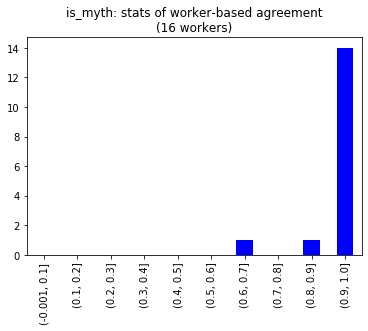

In [108]:
check_worker_based_score("is_myth")

/home/app59/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Avg worker-based score for is_myth_supports = 0.7569844623763388
There are 15 good workers
There are 1 bad workers
['AIQB7XXL5K2FR']


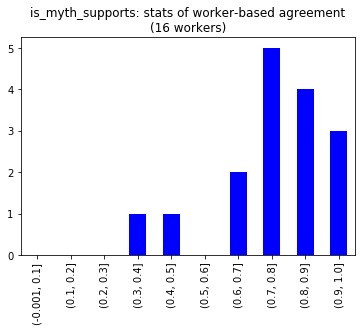

In [109]:
check_worker_based_score("is_myth_supports")

## 3 Alpha agreement score

In [110]:
from nltk.metrics import agreement

data = df[['WorkerId', 'HITId', 'is_myth']].values

data = [ e for e in data if e[2] != 'unsure' ]

rating = agreement.AnnotationTask(data=data)

#print("kappa " + str(rating.kappa()))
#print("fleiss " + str(rating.multi_kappa()))
print("alpha " + str(rating.alpha()))
#print("scotts " + str(rating.pi()))

alpha 0.17508650519031144


In [111]:
data = df[['WorkerId', 'HITId', 'is_myth_supports']].values

data = [ e for e in data if e[2] != 'unsure' ]

rating = agreement.AnnotationTask(data=data)

#print("kappa " + str(rating.kappa()))
#print("fleiss " + str(rating.multi_kappa()))
print("alpha " + str(rating.alpha()))
#print("scotts " + str(rating.pi()))

alpha 0.6356989247311828


In [112]:
worker_ids = list(set(df['WorkerId']))
print('There are {} raters'.format(len(worker_ids)))

task_ids = list(set(df['HITId']))
print('There are {} tweets'.format(len(task_ids)))

There are 20 raters
There are 100 tweets


In [113]:
df[['is_myth']].groupby('is_myth').size()

is_myth
no         10
unsure      1
yes       289
dtype: int64

In [114]:
df[['is_myth_supports']].groupby('is_myth_supports').size()

is_myth_supports
no        152
unsure     49
yes        99
dtype: int64

# 4. Check topics with multiple selection

In [115]:
def is_equal_values(values):
    if values is None or len(values) == 0:
        return False
    
    v = values[0]
    for i in range(len(values)):
        if values[i] != v:
            return False
        
    return True

def get_majority_vote_and_score(df_same_HIT, col):
    """
    Get majority vote and score from the given column
    """
    
    # print(df_same_HIT.shape)
    
    votes = df_same_HIT.groupby(col).size().sort_values(ascending=False)
    if len(votes.values) > 1 and is_equal_values(votes.values):
        is_col = 'unsure'
    else:
        is_col = votes.index[0]
    score = votes.values[0] / rater_num
    
    # In case the vote is `unsure` and the second vote has the same score but not all choices have same scores
    # We use the second vote instead
    if is_col == 'unsure' and votes.size > 1 and \
        votes.values[0] == votes.values[1] and not is_equal_values(votes.values):
        is_col = votes.index[1]
        score = votes.values[1] / rater_num
        
    return is_col, score

In [116]:
# Get the labels from majority votes
df = df.sort_values(by=['HITId']) # Sort by taskID

# Create new dataframe
df_new = pd.DataFrame(columns=['tweet_id', 'text', \
                               'is_myth', 'myth_score', \
                               'is_myth_supports', 'myth_supports_score'])
j = 0
for i in trange(0, df.shape[0], rater_num):
    is_myth, myth_score = get_majority_vote_and_score(df.iloc[i:i+rater_num], 'is_myth')
    is_myth_supports, myth_supports_score = get_majority_vote_and_score(df.iloc[i:i+rater_num], 'is_myth_supports')
    
    tweet_id = df.iloc[i]['Input.id_str']
    text = df.iloc[i]['Input.full_text_censored']
    df_new.loc[j] = [tweet_id, text, is_myth, myth_score, is_myth_supports, myth_supports_score]
    j += 1

100%|██████████| 100/100 [00:00<00:00, 151.31it/s]


In [117]:
tweet_ids_myth_no = list(df_new[df_new['is_myth']=='no']['tweet_id'].astype(str))

In [118]:
df_is_myth_no = df[df['Input.id'].isin(tweet_ids_myth_no)].sort_values(by=['Input.id']).reset_index(drop=True)
df_is_myth_no.shape

KeyError: 'Input.id'

In [ ]:
for idx, text in enumerate(df_is_myth_no.drop_duplicates(subset=['HITId'])['Input.full_text_censored']):
    print("### Tweet-{}".format(idx+1))
    print(text+"\n")

In [ ]:
agree_on_topic = defaultdict(set)

no_vote_at_all_count = 0

for idx, row in df_is_myth_no.iterrows():
    if idx % rater_num == 0:
        counts = defaultdict(int)
        have_voted = False
    
    for topic in topics:
        if row[topic]:
            counts[topic] += 1
            have_voted = True
            
        if counts[topic] >= rater_num:
            agree_on_topic[rater_num].add((row['Input.full_text_censored'], topic))
        
        if counts[topic] >= rater_num - 1:
            agree_on_topic[rater_num - 1].add((row['Input.full_text_censored'], topic))
            
    if idx % rater_num == rater_num - 1 and not have_voted:
        no_vote_at_all_count += 1
            
print("There are {} tweets that {} workers agreed on at least one topic".format(len(agree_on_topic[rater_num]), rater_num))
print("There are {} tweets that {} workers agreed on at least one topic".format(len(agree_on_topic[rater_num-1]), rater_num-1))

print("There are {} tweets with no vote for topics".format(no_vote_at_all_count))

# See how many are not covid-related
not_covid_count = 0
for idx, (text, topic) in enumerate(agree_on_topic[rater_num]):
    if topic == "Answer.Not Related to Coronavirus.on":
        not_covid_count += 1
print("Of those {}, there are {} tweets were voted on not-covid-related topic".format(len(agree_on_topic[rater_num]), not_covid_count))

not_covid_count = 0
for idx, (text, topic) in enumerate(agree_on_topic[rater_num-1]):
    if topic == "Answer.Not Related to Coronavirus.on":
        not_covid_count += 1
print("Of those {}, there are {} tweets were voted on not-covid-related topic".format(len(agree_on_topic[rater_num-1]), not_covid_count))

# print all
for idx, (text, topic) in enumerate(agree_on_topic[rater_num]):
    print("### Tweet-{}: topic='{}'".format(idx+1, topic))
    print("Text: {}\n".format(text))